# Learning to Rank 

## Introduction

Learning to rank models are a special category of ML models

Here's why



here's how training data for a learning to rank problem would look like

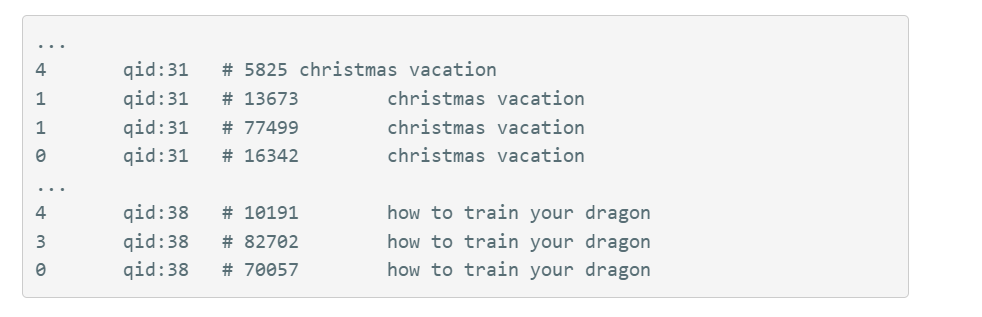

Where column 1 is a human labeled relevance ranking (4 being the highest, 0 being the lowest), column 2 is the ID of the query given by the user , column 4 is the text of the query given by the user, column 3 is the ID of the document (in this case a movie name fetched)

So , for example, the user gave a query  with query ID 31, christmas vacation, and that gave 4 hits (movies with ID 5825, 13673, 77499, 16342). The human labeled relevance for the 4 hits are 4,1,1,0 respectively and we're good .

We now want to use this data to train a model

In this problem, each query gives multiple rows and lives as a group - for example, all the 4 hits with query ID 31 form 1 group, and the ML problem statement is to build a ranking model off it

Note that this is very different from a traditional point wise ML problem, where every row is in theory independent of other rows (IID's), and there's no concept of groups

## How is this different or similar to recommendation engines ?

In brief, LTR algorithms need a user provided query
Recommendation engines do not in general, they look at the user profile and suggest recommendations, without the need for a query

Of course, its not so clear cut as all that, even in recomm. engines, there is search (like searching for a movie in netflix)

But if you think of 3 broad inputs - list of items, query, and user profile

In general, LTR uses query and list of items; and recommendation uses user profile and list of items

You could certainly have a common system which uses all 3

There are some other operational differences, since recommendation systems use user profile input, they are often personalized, and hence need to handle sparsity better

Also, ranking systems should answer the query; whereas for recommendations, in addition to showing only what the user wants, you might want to encourage some diversity

## Metrics

We've already talked elsewhere about metrics for a ranking algorithm, this includes ordered metrics (such as Mean Reciprocal Rank (MRR), MAP (mean average precision), nDCG (normalized distributed cumulative gain)) and unordered metrics such as precision and recall

## Approaches

Typically, these models go through a retrieval step first (approximate NN search, which we've dealt with exhaustively)), or even like a simple BM25, which narrows the search space of documents given a query (for example go from billions of documents to 100s)

and then run a ranking algorithm on top of the 100s to get a ranked list of hits

In the NLP world, you could use sentence embeddings for the retrieval step (either encoder based, decoder based, or encoder-decoder based, typically built using bi-encoders); and then use a cross-encoder BERT architecture to predict a probability of a (query, document) pair for all the retrieved documents, rank then by the probabilities

This falls in a point-wise approach

More generally, LTR ranking systems can be divided into 3 approaches - 

1) pointwise

Here , we assume every query-document pair in the training data has a numerical or ordinal score. Then this can be approximated as a traditional regression/classification problem like we saw in the cross-encoder approach


Note that one problem with this approach is that  we are optimising for being close to label (like traditional classification/regression) and not for ranking documents.







2) Pairwise

Here, LTR is approximated as a classification problem, which takes the query, and document pairs as inputs instead of a single document. Given a query, and a pair of documents, the goal of classification is to say which of the pair is a better match for the query

Here's a loss formulation for this

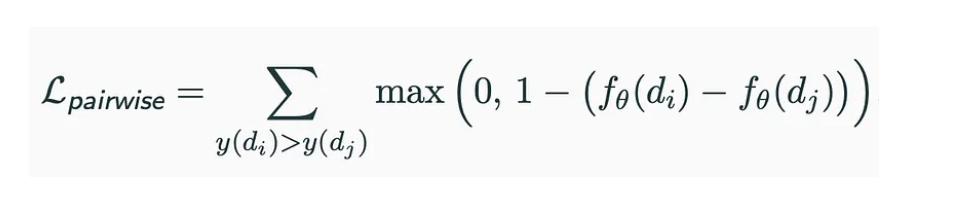

The way to interpret this

we want the score of the relevant document di to be higher than the not so relevant document dj, by a margin of atleast 1 (can be m to generalize); where q is the query

So we want f(q,di) - f(q,dj) >= 1

In other words, we want to maximize (f(q,di)-d(q,dj)) - 1
or minimize 1 - (f(q,di)-f(q,dj))

Of course, if this is already less than 0  (ie f(q,di)-f(q,dj)>=1 already before training), then we want loss to be 0

So loss = max(0, 1 - (f(q,di)-f(q,dj)) ) which we want to minimize


Note that this is very similar to contrastive loss, the only difference is that in contrastive loss, we chose similar and different examples explicitly, the base formulation of pairwise loss I think ddoes not

Example : RankNet

RankNet is a pairwise LTR algorithm which came out in 2005, and was very popular as late as 2015 (maybe still ? )


It uses a slightly different formulation than above

Let's say f(q,di) = si  and f(q,dj) = sj (two scores)

Earlier, we were using si and sj and maximizing distance between them

Now, think of it like a two tower or a biencoder network
You pass (q,di) joint through a network to get a score si
Pass (q,dj) joint through the same network to get a score sj

Now apply softmax on them to get probability pi and pj (pi + pj = 1)

Now, let's assume i was the more relevant document from GT, so yi = 1, and yj = 0

Now we just use a standard cross entropy loss 

minimize -yi * log(pi) -yj * log(pj) = -log(pi)

Sum over all queries and documetn pairs and minimize





You can extend the same RankNet paradigm from pairwise to N documents for a query

The implication of this is that we get N scores s1, s2, s3.. sN instead of the 2 scores in the binary formulation

Then you take softmax over the N scores to get N probabilities p1.. pN

And your cost function will still be minimize -log(pi) where i is the highest ranked document

Similar  to negative sampling used in W2vec, instead of a softmax over all documents which is expensive, we can use the negative sampling approach, sampling 1 positive and K negative, and using softmax instead




3) Listwise

These metrics directly try to optimize metrics of interest such as nDCG, averaged over all the queries in the dataset. Usually harder to implement as these metrics are not continuous and hence not differentiable

So how do we solve this ?

1. Use probabilistic approximations of ranking (eg. ListNet)
2. Use heuristics or bounds on metrics (eg. LambdaRank, LambdaLoss)

For example , here is the Lambda Rank equation

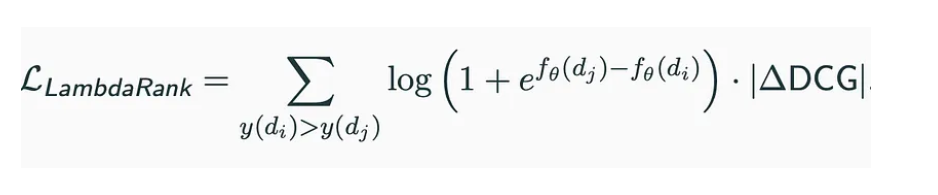

which is a proven bound on DCG

Liks pairwise, we sum over document pairs, but weight according to how much DCG changes when you switch a pair


Example : ListNet

Before going into details, why is list wise loss even necessary ? Isn't pair wise sufficient ?

No, look at the example below

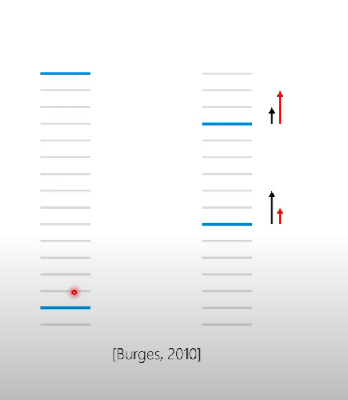

The ranking on the left is better using metric like nDCG, etc , since one relevant output is at the top.

However, pairwise loss will kind of prefer the ranking on the right . Why ?

Think about it like this - Looking at the top correct answer in both the left and right ranking scenarios, the right one is 4 swaps worse than the left one (top hit is on position 1 on left, and position 5 on right).

However, the bottom correct answer is 5 swaps worse in the left one than the right (on left, the blue line is second from bottom, on right, seventh from bottom)

So overall, +4-5, which means the left ranking is worse than the right in a pairwise loss scenario



Here is an example of using transformer architectures in a different way (not point wise as mentioned earlier using cross-encoders, but list wise ranking)

Use an encoder only architecture

Encode the whole list of items as a sequence ! Each item gets one embedding

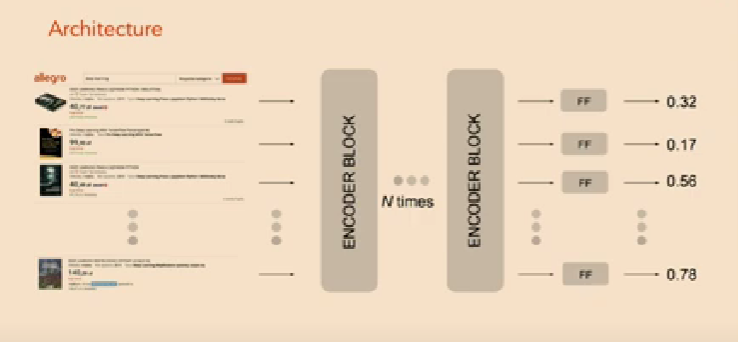

This allows you to capture intra item dependencies during the self-attention block

Of course, even this is applied only after the retrieval step using ANN, to get computational advantange, and rank only a small no of items

How do we encode the position in the positional encoding above though ? (If not for positional embedding, attention ignores sequence) - Using learnt embeddings ? Or ROPE ?

Here are the metrics of the above self-attention apporoach over MLP and XGBoost models on a public data set (WEB30K) acc to reference below. NDCG reported is NDCG@5


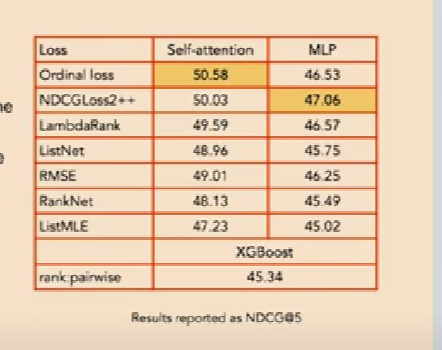

On a variety of metrics, the self-attention approach seems to do better
No idea what exactly the metrics mean 

### Smooth DCG

Ranking is not differentiable, as we mentioned already

So given a query, and a set of documents, you have a differentiable model f which actors on this and produces 10 different scores.

Given these scores, how do you rank these documents without sorting ? (As sorting is not differentiable)

Define a function G which takes 2 scores , gives a 1 if score1 > score2, 0 otherwise

Now the rank of document di is 1 + the number of other documents in the set who have a higher score than di. (If there are 2 other documents with a score higher than score of di, di will have rank 3)


So  we get this formula 

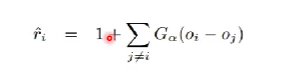

ie rank of ith document is 1 + the number of other documents whose score is greater than current documetn

So given K documents, compare document i to all other K-1 documents, apply function G, sum to get the rank


So now all of this is differentiable except G which is an indicator RV

To fix this, Approximate G as a sigmoid(scorei - scorej)


This smooth rank can be plugged to any ranking metric like nDCG or MRR, to get smooth nDCG or smooth MRR


How do you know which of these 3 kinds of metrics to use ? Point wise, pairwise and listwise ?

In practice, generally, listwise has been seen to work the best.

However, depending on the particular situation, point wise or pairwise might be needed

For example, if in addition to ranking, you also want to know how much more better a particular item is compared to the others, you need point wise to get probabilities

Similarly, if you want only the top 1 rank displayed to the user in some particular scenario, listwise doesn;t make sense

## References

1) https://softwaredoug.com/blog/2021/11/28/how-lammbamart-works
2) https://en.wikipedia.org/wiki/Learning_to_rank
3) https://medium.com/@mayurbhangale/pointwise-pairwise-and-listwise-learning-to-rank-baf0ad76203e
4) https://www.youtube.com/watch?v=44vX7QDD3VQ - nice video on applying transformers to lists of items
5) https://www.youtube.com/watch?v=2UpLin5T_E4 - good intro to LTR
6) https://www.youtube.com/watch?v=1uut7IGStw8 - Very nice video on LTR, with some neural architectures